# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp ffp

In [ ]:
#| hide
from nbdev.showdoc import *

In [219]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad, tplquad
from scipy.interpolate import interp1d, interp2d
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool


In [220]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
#| export

# Disk Density
def zthin(r):
    if r > 4.5:
        return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
    else:
        return zthin45

def rho_thin_mw(r, 
             z,
            ) -> float: # FFP density in Msun/kpc^3

    if r > rdBreak:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((r - rsol) / rthin)) * \
            (1 / np.cosh(-np.abs(z) / zthin(r)))**2
    else:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((rdBreak - rsol) / rthin)) * \
            (1 / np.cosh(-np.abs(z) / zthin(r)))**2
    
    return result 

def rho_thick_mw(r, 
              z, 
            ) -> float: # FFP density in Msun/kpc^3
    
    if r > rdBreak:
        result = rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))
    else:
        result = rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))

    return result 

# Bulge Density
def rsf(xp, yp, zp):
    rs = (((xp/x0)**cperp + (yp/y0)**cperp)**(cpar/cperp) + (zp/z0)**cpar)**(1/cpar)
    return rs

def fE(xp, yp, zp):
    return np.exp(-rsf(xp, yp, zp))

def cut(x):
    if x > 0:
        return np.exp(-x**2)
    else:
        return 1

def rho_bulge_mw(d: float,
            ) -> float: # FFP density in Msun/kpc^3
    xp, yp, zp = get_primed_coords(d)
    xp, yp, zp = abs(xp), abs(yp), abs(zp)
    r = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((r - Rc) / 0.5)

# Total FFP Density
def rho_FFPs_mw(d: float, # distance from Sun in kpc
             ) -> float: # FFP density in Msun/kpc^3
    r = dist_mw(d)
    _, _, z = get_primed_coords(d)
    return (rho_thin_mw(r, z) + rho_thick_mw(r, z) + rho_bulge_mw(d)) 

def m_avg_ffp(m_low, alpha):
    masses = m_low * (1 - np.random.rand(int(1e4)))**(-1 / (alpha - 1))
    masses[masses > m_high_interp] = m_high_interp
    return np.mean(masses)

m_low_ffp_interp = 1e-15
m_high_interp = 1e0
alpha_low_interp = 1
alpha_high_interp = 3

def make_m_avg_interp(n_points=40):
    alpha_arr = np.linspace(alpha_low_interp, alpha_high_interp, n_points)
    m_arr = np.logspace(np.log10(m_low_interp), np.log10(m_high_interp), n_points) #solar masses

    def calc_m_avg_arr(m):
    # Calculate ut_arr for the current m
        return np.array([m_avg_ffp(m, alpha) for alpha in alpha_arr])
    
    with Pool() as p:
        m_avg_values = list(p.map(calc_m_avg_arr, m_arr))

    # Convert ut_values to a 2D array
    m_avg_values = np.array(m_avg_values)
    
    # Create the 2D interpolation table
    m_avg_interp = interp2d(m_arr, alpha_arr, m_avg_values)
    return m_avg_interp

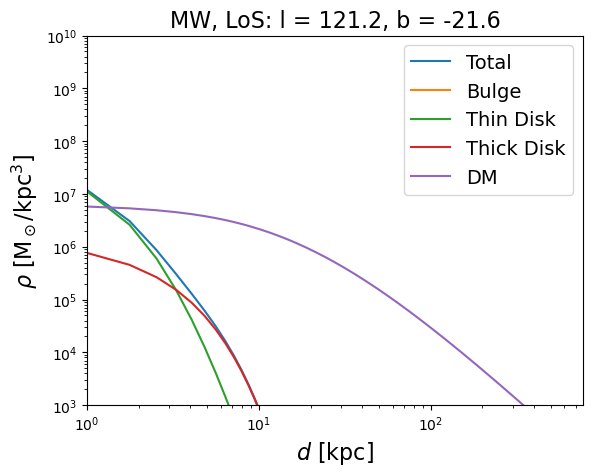

In [183]:
# Define values for the x-axis

# d_arr = np.logspace(-2, np.log10(ds), num=100)
d_arr = np.linspace(1, ds, num=1000)


z_arr = [d* np.sin(np.deg2rad(b)) for d in d_arr]
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_mw(i) for i in d_arr]
rho_bulge_arr = [rho_bulge_mw(i) for i in d_arr]
rho_thin_arr = [rho_thin_mw(dist_mw(d_arr[i]), z_arr[i]) for i in range(len(d_arr))]
rho_thick_arr = [rho_thick_mw(dist_mw(d_arr[i]), z_arr[i]) for i in range(len(d_arr))]
rho_dm_arr = [density_mw(dist_mw(d_arr[i])) for i in range(len(d_arr))]

# Create the log plot
plt.plot(d_arr, rho_total_arr, label="Total")
plt.plot(d_arr, rho_bulge_arr, label="Bulge")
plt.plot(d_arr, rho_thin_arr, label="Thin Disk")
plt.plot(d_arr, rho_thick_arr, label="Thick Disk")
plt.plot(d_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('MW, LoS: l = {}, b = {}'.format(l,b), fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e3, 1e10)

plt.show()


In [222]:
#| export
# Add stellar distribution of M31 following: https://www.aanda.org/articles/aa/pdf/2012/10/aa20065-12.pdf

def einasto(a, rhoc, dn, ac, n):
    return rhoc * np.exp(-dn *((a/ac)**(1/n) - 1))

def rho_bulge_m31(a, 
                ) -> float: # FFP density in Msun/kpc^3
    rhoc = 9.201e-1 * (1e3)**3 #Msun/kpc^3
    dn = 7.769
    ac = 1.155 #kpc
    n = 2.7
    return einasto(a, rhoc, dn, ac, n) 

def rho_disk_m31(a,
                    ) -> float: # FFP density in Msun/kpc^3
    rhoc = 1.307e-2 * (1e3)**3 #Msun/kpc^3
    dn = 3.273
    ac = 10.67 #kpc
    n = 1.2
    return einasto(a, rhoc, dn, ac, n) 

def rho_nucleus_m31(a,
                    ) -> float: # FFP density in Msun/kpc^3
    rhoc = 1.713 * (1e3)**3 #Msun/kpc^3
    dn = 11.668
    ac = 0.0234 #kpc
    n = 4.0
    return einasto(a, rhoc, dn, ac, n) 

def rho_FFPs_m31(a: float, # distance from center of M31 in kpc
             ) -> float: # FFP density in Msun/kpc^3
    return (rho_bulge_m31(a) + rho_disk_m31(a) + rho_nucleus_m31(a))

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/utils.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


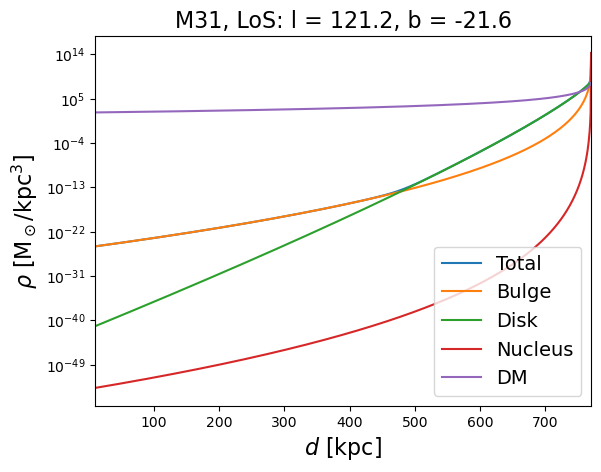

In [195]:
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_m31(dist_m31(d)) for d in d_arr]
rho_bulge_arr = [rho_bulge_m31(dist_m31(d)) for d in d_arr]
rho_disk_arr = [rho_disk_m31(dist_m31(d)) for d in d_arr]
rho_nucleus_arr = [rho_nucleus_m31(dist_m31(d)) for d in d_arr]
rho_dm_arr = [density_m31(dist_m31(d)) for d in d_arr]

# Create the log plot
plt.plot(d_arr, rho_total_arr, label="Total")
plt.plot(d_arr, rho_bulge_arr, label="Bulge")
plt.plot(d_arr, rho_disk_arr, label="Disk")
plt.plot(d_arr, rho_nucleus_arr, label="Nucleus")
plt.plot(d_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('M31, LoS: l = {}, b = {}'.format(l,b), fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
# plt.xscale("log")
plt.xlim(1e1, ds)

# Show the plot
plt.show()

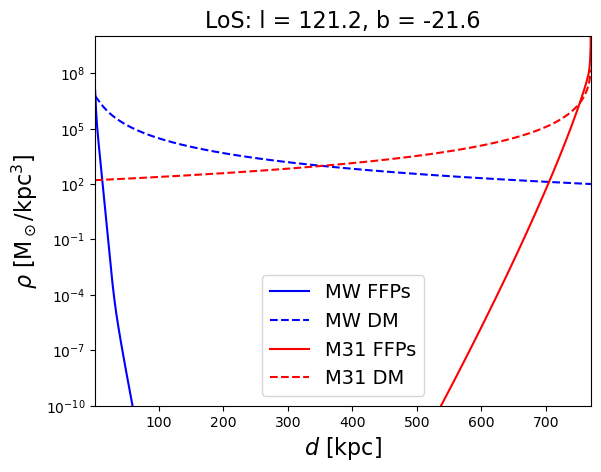

In [196]:
# Define values for the x-axis

# d_arr = np.logspace(-2, np.log10(ds*0.999), num=100)

# Calculate the density values for each component
rho_ffp_mw = [rho_FFPs_mw(i) for i in d_arr]
rho_ffp_m31 = [rho_FFPs_m31(dist_m31(i)) for i in d_arr]
rho_dm_mw = [density_mw(dist_mw(i)) for i in d_arr]
rho_dm_m31 = [density_m31(dist_m31(i)) for i in d_arr]

# Create the log plot
plt.plot(d_arr, rho_ffp_mw, label="MW FFPs", color="blue")
plt.plot(d_arr, rho_dm_mw, label="MW DM", color="blue", linestyle="--")
plt.plot(d_arr, rho_ffp_m31, label="M31 FFPs", color="red")
plt.plot(d_arr, rho_dm_m31, label="M31 DM", color="red", linestyle="--")
# plt.plot(d_arr, rho_total_arr, label="FFPs")
# plt.plot(d_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('LoS: l = {}, b = {}'.format(l,b), fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
# plt.xscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e-10, 1e10)

# Show the plot
plt.show()

In [ ]:
#| hide
# m_avg_interp = make_m_avg_interp(n_points=40)
# with open('../interpolations/m_avg_interp.pkl', 'wb') as f:
#     pickle.dump(m_avg_interp, f)

In [223]:
#| export
class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                p: float = 2, # Mass function power law index
                ):
        """
        Initialize the PBH population
        """
        
        self.ut_interp = ut_interp
        self.p = p
        #Define range of power law we want to consider
        self.m_min = 1e-15
        self.m_max = 1e-5
        self.Z = self.pl_norm(self.p)


    def __str__(self) -> str:
        return f"FFP with power law ~ m^-{self.p}"
    __repr__ = __str__

    def mass_func(self, m):
        #M_norm = 1 solar mass for now
        return (m / 1) ** -self.p
    
    def pl_norm(self, p):
        N_ffp = 1 # Number of FFPs per star
        return N_ffp/abs(nquad(self.mass_func,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3]})[0])

    def differential_rate_integrand(self, umin, d, mf, t, dist_func, density_func, v_disp_func, finite=False, density_func_uses_d=False):
        r = dist_func(d)
        ut = self.umin_upper_bound(d, mf) if (self.ut_interp and finite) else 1
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut)  
        v_disp = v_disp_func(r)
        density_input = d if density_func_uses_d else r
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                        #For FFP number density, use stellar density for 1 solar mass stars
                density_func(density_input) / (1 * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)


    def differential_rate(self, t, integrand_func, finite=False):
        num = 20  # number of discretization points
        mf_values = np.logspace(np.log10(self.m_min), np.log10(self.m_max), num=num)
        result = 0
        for i in range(num):
            mf = mf_values[i]
            if i == 0:  # for the first point
                dm = mf_values[i+1] - mf_values[i]
            elif i < num - 1:  # for middle points
                dm = ((mf_values[i+1] - mf_values[i]) + (mf_values[i] - mf_values[i-1])) / 2
            else:  # for the last point
                dm = mf_values[i] - mf_values[i-1]
            #TODO These errors are too big currently. Think about splitting up integral
            if finite:
                single_result, error = dblquad(integrand_func, 
                                            0, ds, 
                                            lambda d: 0, 
                                            lambda d: self.umin_upper_bound(d, mf),
                                            args=(mf, t))
            else:
                single_result, error = dblquad(integrand_func,
                                            0, ds,
                                            lambda d: 0, 
                                            lambda d: ut,
                                            args=(mf, t))
            result += single_result * (mf ** -self.p) * dm  # multiply by mass function and by dm
            # print(error/single_result)
        result *= self.Z  # normalization
        return result
        

    def differential_rate_integrand_mw(self, umin, d, mf, t, finite=False):
        return self.differential_rate_integrand(umin, d, mf, t, dist_mw, rho_FFPs_mw, velocity_dispersion_mw, finite=finite, density_func_uses_d=True)

    def differential_rate_mw(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)

    def differential_rate_integrand_m31(self, umin, d, mf, t, finite=False):
        return self.differential_rate_integrand(umin, d, mf, t, dist_m31, rho_FFPs_m31, velocity_dispersion_m31, finite=finite, density_func_uses_d=False)

    def differential_rate_m31(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)

    def umin_upper_bound(self, d, m):
        if self.ut_interp is None:
            self.make_ut_interp()
        return self.ut_interp(d, m)[0]
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [199]:
p = 2
f = Ffp(p)
f

FFP with power law ~ m^-2

In [200]:
ts = np.logspace(-8, np.log10(1e3), num=20)
diff_rates = f.compute_differential_rate(ts, finite=False)
diff_rates_finite = f.compute_differential_rate(ts, finite=True)

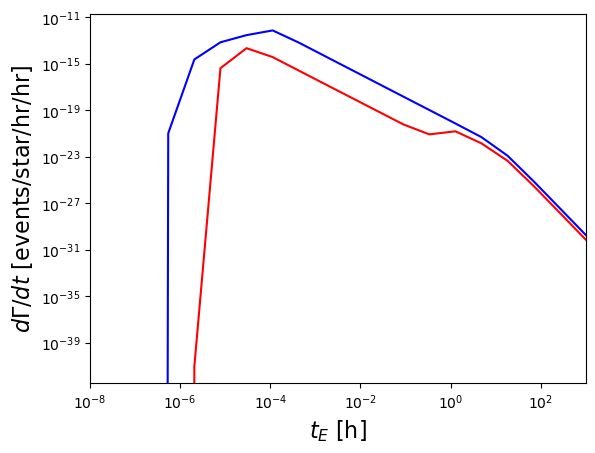

In [201]:
plt.loglog(ts, diff_rates, color="blue")
plt.loglog(ts, diff_rates_finite, color="red")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
# plt.xlim([0.009, 1e3])
# plt.ylim([1e-20, 1e-7])
plt.xlim(min(ts), max(ts))
plt.show()

In [202]:
def crossing_time(m, d):
    #rough crossing time in hours
    return 0.5* (m/1e-8)**(0.5) * (d/100)**0.5


In [203]:
print(scientific_format(crossing_time(1e-15, 100),1))
#So it makes sense the rate is peaked for t~1e-4 hours since that is the crossing time for the smallest mass, which contributes the most

$1.6 \times 10^{-4}$


### Look at cutoff mass

In [224]:
def get_n_events(A, alpha=2, finite=False):
    #Now A is number of FFPs per star
    f = Ffp(alpha)
    ti = 0.07
    tf = 3
    diff_rates = f.compute_differential_rate(ts, finite=finite)
    rate_interp = interp1d(ts, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return n_sources*efficiency*dnds*obsTime*A

def get_constraint_iso(m_iso, alpha=2, finite=False):
    if m_iso < 1e-15:
        raise ValueError('Mass must be greater than 1e-15')
    
    n_events = get_n_events(1, alpha=alpha, finite=finite)
    f = Ffp(alpha)

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(f.mass_func,[[m_iso, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3]})[0]*f.Z

    #Maximum number of total allowed ISOs per star
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

In [225]:
get_n_events(1, alpha=2.13, finite=True)
#!Why doesnt this line up with hsc_ffp.ipynb?

1.9714649526098465e-13

In [226]:
get_constraint_iso(1e-7, alpha=2.13, finite=True)

21807.007514910885

In [227]:
get_constraint_iso(1e-7, alpha=2, finite=True)

29657.485657012698

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()